In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
# Read in dataset
df_log = pd.read_csv("C:/Users/djcsr/Documents/Semester 9/CGS4144 Bioinformatics/Analysis/data/SRP073813/SRP073813_log.csv")
df_meta = pd.read_csv("C:/Users/djcsr/Documents/Semester 9/CGS4144 Bioinformatics/Analysis/data/SRP073813/SRP073813_meta.csv")

In [5]:
df_log.set_index("HUGO", inplace = True)
df_meta.set_index("ID", inplace = True) 
df_meta = df_meta['refinebio_subject'] #removes unnecessary data 

In [6]:
df_meta = df_meta.to_frame()

In [7]:
df_log =round(df_log) 
df_log = df_log.T #swaps columns and indexes
df_log = df_log.join(df_meta)

In [8]:
df_log = df_log.loc[:, ~df_log.columns.duplicated()] #removes duplicate columns

In [9]:
#Transfomring the data to contain only NACC tissue samples
df_log = df_log[df_log["refinebio_subject"].str.contains('nacc')]
df_meta = df_meta[df_meta["refinebio_subject"].str.contains('nacc')]

In [10]:
df_log.drop("refinebio_subject",axis =1,inplace = True)

In [11]:
df_log = df_log.T

In [12]:
# Sort genes by variance and create subsets from 10 to 10000
df_log["variance"] = np.var(df_log.values, axis=1)
df = df_log.sort_values("variance", ascending=False)
df.drop("variance", axis =1, inplace = True)
dfTen = df.head(10).T
dfHun = df.head(100).T
dfThous = df.head(1000).T
dfTenThous = df.head(10000).T
dfFiveThous = df.head(5000).T

In [13]:
dfFiveThous = dfFiveThous.join(df_meta)
dfTen = dfTen.join(df_meta)
dfHun = dfHun.join(df_meta)
dfThous = dfThous.join(df_meta)
dfTenThous = dfTenThous.join(df_meta)

In [14]:
# Above code is from assignment 3

In [97]:
def make_model(df):
    y = df.refinebio_subject
    cols = np.delete(df.columns, len(df.columns)-1,0)
    x = df[cols]
    model = LogisticRegression(solver='newton-cg', multi_class='multinomial', random_state=0)
    x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.2, random_state=1)
    model.fit(x_train, y_train) 
    y_pred = model.predict(x_test)
    accuracy = model.score(x_test, y_test)
    print(f"{len(df.columns)-1} Genes Accuracy: {accuracy:.2f}")
    model.fit(x,y)
    return model

In [98]:
tenModel = make_model(dfTen)
hunModel = make_model(dfHun)
thousModel= make_model(dfThous)
fiveThousModel= make_model(dfFiveThous)
tenThousModel = make_model(dfTenThous)

10 Genes Accuracy: 0.17
100 Genes Accuracy: 0.30
1000 Genes Accuracy: 0.43
5000 Genes Accuracy: 0.43
10000 Genes Accuracy: 0.43


In [115]:
tenModel.coef_

array([[ 0.27189203,  0.00360854, -0.70593841,  0.33849083,  0.27572362,
        -0.55194277,  0.61618406, -0.32492251, -0.00106028,  0.06256167],
       [-0.23815203, -0.22506287,  0.33480906, -0.09899949, -0.24929096,
         0.68902053, -0.48633432,  0.30114973, -0.73380503,  0.39923997],
       [ 0.00265727, -0.308728  ,  0.35236862,  0.04934465,  0.12167407,
        -0.10354871, -0.45189317,  0.06988302, -0.12134876,  0.24814212],
       [-0.03639727,  0.53018233,  0.01876073, -0.28883599, -0.14810674,
        -0.03352905,  0.32204343, -0.04611025,  0.85621407, -0.70994377]])

In [102]:
np.absolute(tenModel.coef_)

array([[0.27189203, 0.00360854, 0.70593841, 0.33849083, 0.27572362,
        0.55194277, 0.61618406, 0.32492251, 0.00106028, 0.06256167],
       [0.23815203, 0.22506287, 0.33480906, 0.09899949, 0.24929096,
        0.68902053, 0.48633432, 0.30114973, 0.73380503, 0.39923997],
       [0.00265727, 0.308728  , 0.35236862, 0.04934465, 0.12167407,
        0.10354871, 0.45189317, 0.06988302, 0.12134876, 0.24814212],
       [0.03639727, 0.53018233, 0.01876073, 0.28883599, 0.14810674,
        0.03352905, 0.32204343, 0.04611025, 0.85621407, 0.70994377]])

In [93]:
gene_name = np.delete(dfHun.columns, len(dfHun.columns)-1,0)
gene_name

Index(['CHI3L1', 'PENK', 'PTPN5', 'SYNDIG1L', 'XIST', 'HSPA1A', 'RAP1GAP',
       'PEG3', 'MOBP', 'NRGN', 'HSPA1B', 'FGFR3', 'CASKIN1', 'SHANK1', 'GRIN1',
       'BCAS1', 'PCSK5', 'TP53INP2', 'RGS14', 'MTSS2', 'PCSK1N', 'PDYN',
       'SLC32A1', 'CPLX1', 'PDZD4', 'PHYHIP', 'SCN4B', 'ANO3', 'DMTN',
       'KCNQ1OT1', 'TF', 'TNK2', 'THY1', 'NGEF', 'HPCA', 'PCDHGC5', 'SDC3',
       'LINGO3', 'TMEM132A', 'LINC00632', 'NCDN', 'ACTG1', 'GNG7', 'FBXL16',
       'ERMN', 'SLC17A7', 'CTXN1', 'PAQR6', 'AGAP2', 'NSG2', 'SERPINA3',
       'PTPRN', 'PSAP', 'MYRF', 'CNTN2', 'SHTN1', 'ATP2B2', 'DDN', 'PALM',
       'PTGDS', 'MAP4K4', 'CARNS1', 'DLGAP3', 'CEP170B', 'OLMALINC', 'CAPS',
       'CCDC144A', 'BAG3', 'AQP4', 'APLP1', 'PSD', 'DAAM2', 'NNAT', 'CERCAM',
       'SEPTIN5', 'ATP1A3', 'RASD2', 'ABCA2', 'CAMKV', 'SEPT5-GP1BB', 'CADM3',
       'SPARC', 'VSNL1', 'GABRA5', 'ACAP3', 'KIFC2', 'CST3', 'NMNAT3',
       'SEMA6B', 'KCNQ2', 'TNPO2', 'VGF', 'WFS1', 'CAMK2A', 'KCNAB2', 'PTPRN2',
       'DNAJB1'

In [103]:
# Above was the machine learning, below is the analysis
cols = np.delete(dfFiveThous.columns, len(dfFiveThous.columns)-1,0)
X = dfFiveThous[cols]

In [116]:
def extract_genes(df, model, threshold):
    gene_names = np.delete(df.columns, len(df.columns)-1,0)
    importances = model.coef_[0]
    significant_genes_rf = [gene_names[i] for i, coef in enumerate(importances) if abs(coef) > threshold]
    return significant_genes_rf

In [117]:
sig_10 = set(extract_genes(dfTen, tenModel, 0.0015))
sig_100 = set(extract_genes(dfHun, hunModel, 0.0015))
sig_1000 = set(extract_genes(dfThous, thousModel, 0.0015))
sig_5000 = set(extract_genes(dfFiveThous, fiveThousModel, 0.0015))
sig_10000 = set(extract_genes(dfTenThous,tenThousModel, 0.0015))

In [118]:
import venn

C:\Users\djcsr\AppData\Local\Programs\Python\Python39\lib\site-packages\venn\_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
C:\Users\djcsr\AppData\Local\Programs\Python\Python39\lib\site-packages\venn\_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((


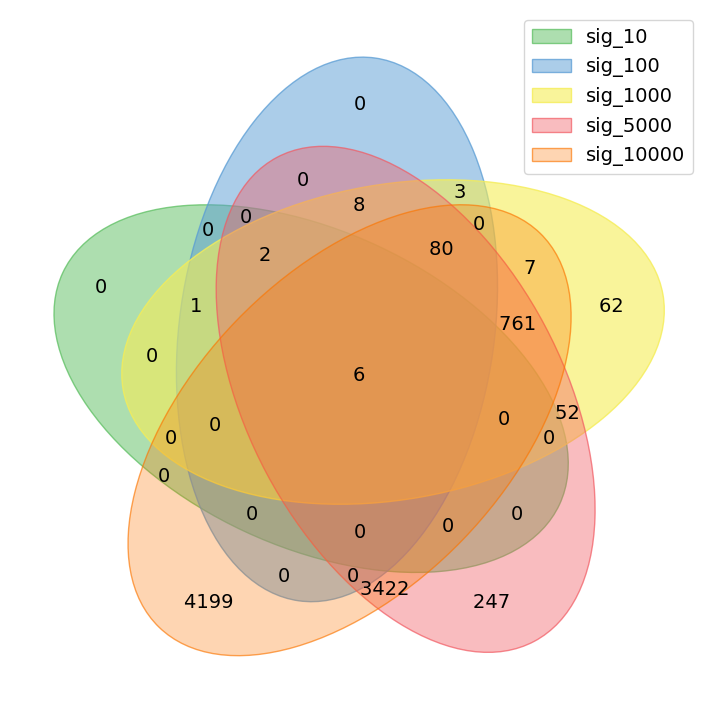

In [119]:
# Define your sets
sets = {
    'sig_10': set(sig_10),
    'sig_100': set(sig_100),
    'sig_1000': set(sig_1000),
    'sig_5000': set(sig_5000),
    'sig_10000': set(sig_10000)
}

# Create the Venn diagram
labels = venn.get_labels([value for key, value in sets.items()], fill=['number'])
fig, ax = venn.venn5(labels, names=list(sets.keys()))